In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt
import numpy as np



# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
torch.manual_seed(2)
torch.cuda.manual_seed(2)

g = torch.Generator()
g.manual_seed(1)


# Data preparation

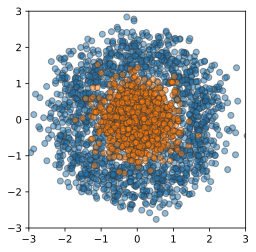

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler

from torch.utils import data as data
from torch.utils.data import DataLoader, TensorDataset

def create_dataloader(data_type, batch_size = 3000, noise = 0.15, factor = 0.15, random_state = 1, shuffle = False, plotlim = [-2, 2]):
    if data_type == 'circles':
        X, y = make_circles(batch_size, noise=noise, factor=factor, random_state=random_state, shuffle = shuffle)
        
        
    elif data_type == 'blobs':
        centers = [[-1, -1], [1, 1]]
        X, y = make_blobs(
    n_samples=batch_size, centers=centers, cluster_std=noise, random_state=0)
        
        
    elif data_type == 'moons':
        X, y = make_moons(batch_size, noise = noise, shuffle = shuffle , random_state = 0)
    
    
    elif data_type == 'xor':
        X = torch.randint(low=0, high=2, size=(batch_size, 2), dtype=torch.float32)
        y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).float()
        # y = y.to(torch.int64)
        X += noise * torch.randn(X.shape)
        
        
    else: 
        print('datatype not supported')
        return None, None

    g = torch.Generator()
    g.manual_seed(random_state)
    
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.05 ) #random_state=2, shuffle = shuffle)

    X_train = torch.Tensor(X_train) # transform to torch tensor for dataloader
    y_train = torch.Tensor(y_train) #transform to torch tensor for dataloader

    X_test = torch.Tensor(X_test) # transform to torch tensor for dataloader
    y_test = torch.Tensor(y_test) #transform to torch tensor for dataloader

    X_train = X_train.type(torch.float32)  #type of orginial pickle.load data
    y_train = y_train.type(torch.int64) #dtype of original picle.load data

    X_test = X_test.type(torch.float32)  #type of orginial pickle.load data
    y_test = y_test.type(torch.int64) #dtype of original picle.load data


    train_data = TensorDataset(X_train,y_train) # create your datset
    test_data = TensorDataset(X_test, y_test)

    train = DataLoader(train_data, batch_size=64, shuffle=shuffle, generator=g)
    test = DataLoader(test_data, batch_size=256, shuffle=shuffle, generator = g) #128 before
    
    data_0 = X_train[y_train == 0]
    data_1 = X_train[y_train == 1]
    fig = plt.figure()
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333",  alpha = 0.5) #color = 'crimson',
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", alpha = 0.5) #color = 'dodgerblue'
    plt.xlim(plotlim)
    plt.ylim(plotlim)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.savefig('trainingset.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
    plt.show()
    
    return train, test


data_noise = 0.25
plotlim = [-3, 3]
dataloader, dataloader_viz = create_dataloader('circles', noise = data_noise, plotlim = plotlim)



#Visualizing the data


In [3]:
#We can now conveniently access the data from the dataloaders
for X_test, y_test in dataloader_viz:
    print(X_test[:10], y_test[:10])
    break
    

tensor([[-0.1490,  1.0127],
        [ 1.0228,  2.0615],
        [-0.9491,  2.1280],
        [ 0.1150,  1.0118],
        [ 1.4200,  0.7695],
        [-0.2969,  0.2246],
        [-2.1022, -0.1135],
        [ 1.3383, -1.4026],
        [-0.1261, -0.4761],
        [ 0.0261, -0.0566]]) tensor([1, 0, 0, 1, 0, 1, 0, 0, 1, 1])


# Model dynamics

In [4]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 5, 5 
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = True
turnpike = False


non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside



torch.manual_seed(2)
torch.cuda.manual_seed(2)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 


print(anode)

    


NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
      )
    )
  )
  (linear_layer): Linear(in_features=2, out_features=2, bias=True)
  (non_linearity): Tanh()
)


In [5]:
torch.manual_seed(2)
torch.cuda.manual_seed(2)
rnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3) 


print(rnode)

NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
      )
    )
  )
  (linear_layer): Linear(in_features=2, out_features=2, bias=True)
  (non_linearity): Tanh()
)


# Classification Plot

In [6]:
import seaborn as sns
from matplotlib.colors import to_rgba, to_rgb
import numpy as np
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

@torch.no_grad()
def classification_evolution(model, fig_name=None, footnote=None, contour = True, plotlim = [-2, 2]):
    
    
    x1lower, x1upper = plotlim
    x2lower, x2upper = plotlim

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    fig = plt.figure(figsize=(5, 5), dpi=300)
    
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.figtext(0.5, 0, footnote, ha="center", fontsize=10)

    
   
    model.to(device)

    x1 = torch.arange(x1lower, x1upper, step=0.01, device=device)
    x2 = torch.arange(x2lower, x2upper, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    
    preds, _ = model(model_inputs)
    
    # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
    m = nn.Softmax(dim=2)
    # softmax normalizes the model predictions to probabilities
    preds = m(preds)

    #we only need the probability for being in class1 (as prob for class2 is then 1- class1)
    preds = preds[:, :, 0]
    preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
    
    plt.grid(False)
    plt.xlim([x1lower, x1upper])
    plt.ylim([x2lower, x2upper])

    ax = plt.gca()
    ax.set_aspect('equal') 
    
    if contour:
        colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is orange, last is blue
        cm = LinearSegmentedColormap.from_list(
            "Custom", colors, N=40)
        z = np.array(preds).reshape(xx1.shape)
        
        levels = np.linspace(0.,1.,8).tolist()
        
        cont = plt.contourf(xx1, xx2, z, levels, alpha=1, cmap=cm, zorder = 0, extent=(x1lower, x1upper, x2lower, x2upper)) #plt.get_cmap('coolwarm')
        cbar = fig.colorbar(cont, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel('prediction prob.')
    

    if fig_name:
        plt.savefig(fig_name + '.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
        plt.clf()
        plt.close()
    # return fig

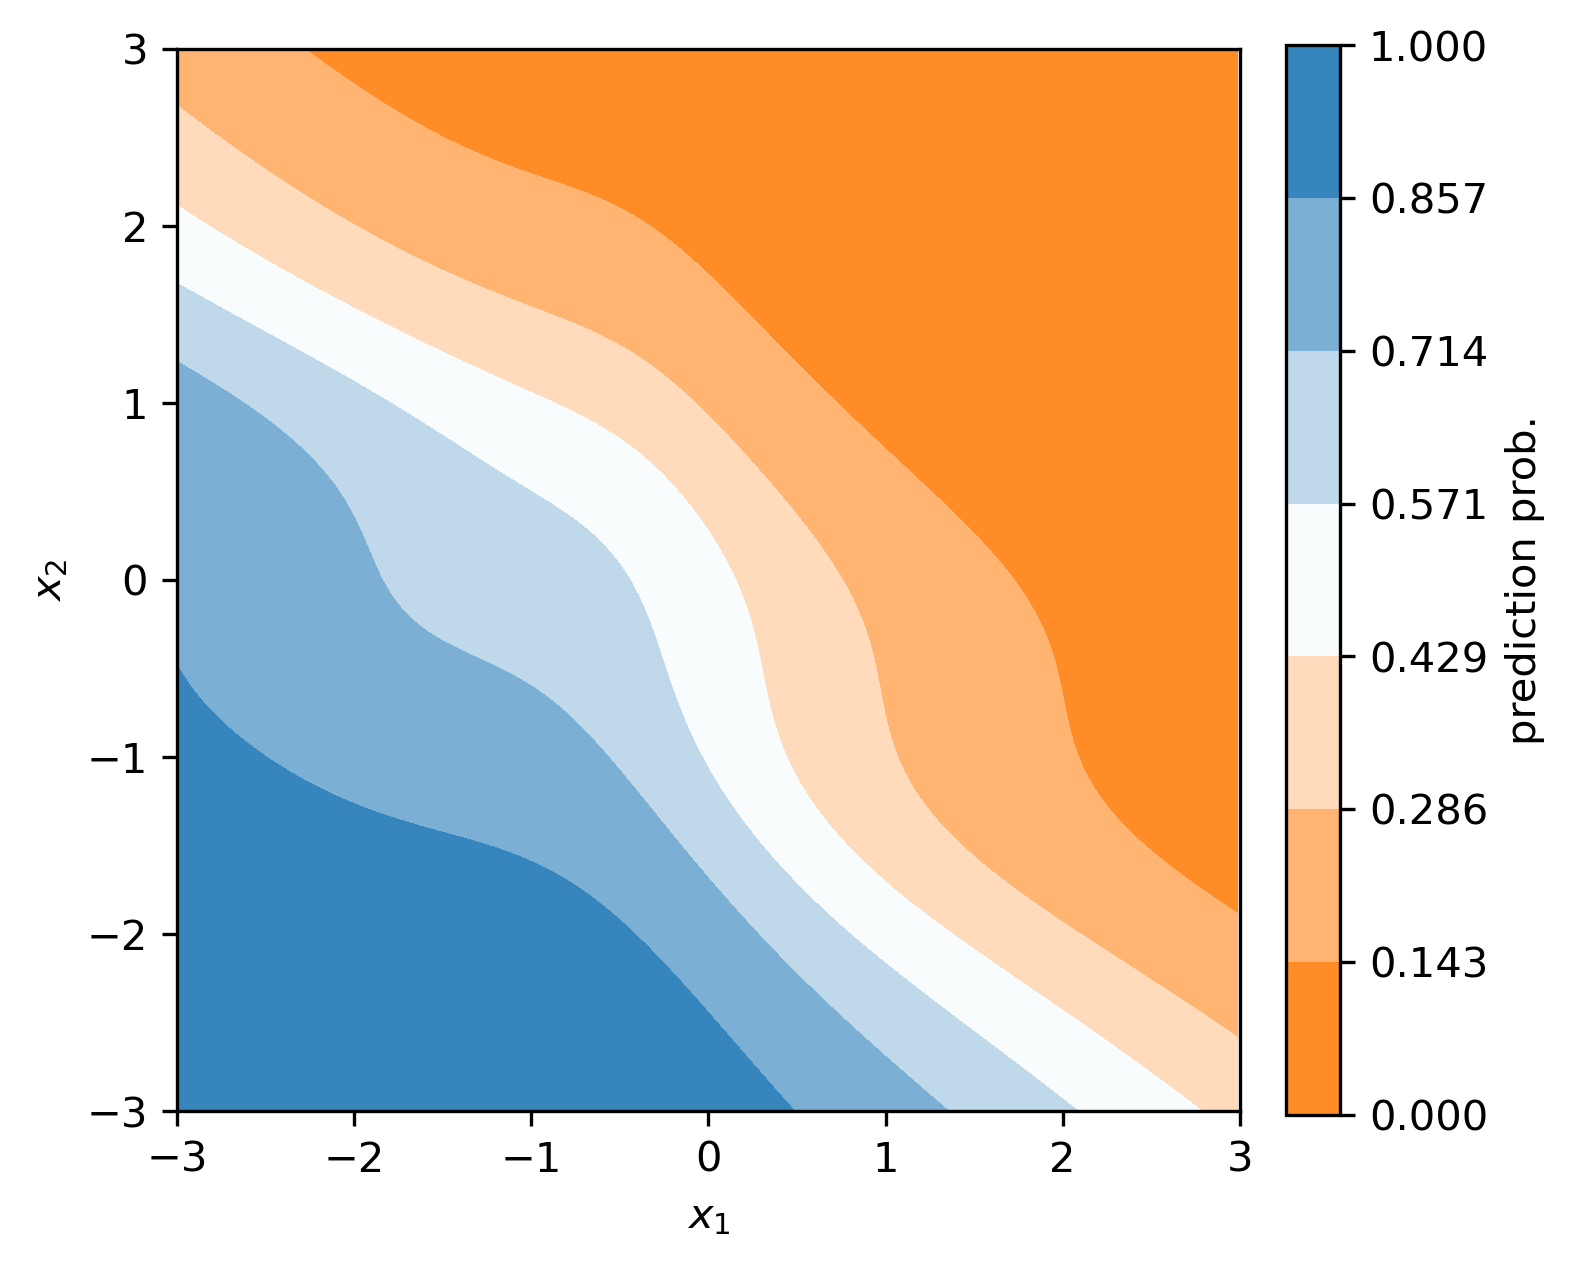

In [7]:
classification_evolution(rnode, fig_name = 'test' , plotlim = plotlim)
from IPython.display import Image
Image(filename = 'test.png', width = 800)

In [8]:
def comparison_plot(fig1, title1, fig2, title2, output_file, figsize = (10,10), show = False):
    plt.figure(dpi = 300, figsize=figsize)
    plt.subplot(121)
    sub1 = imageio.imread(fig1)
    plt.imshow(sub1)
    plt.title(title1)
    plt.axis('off')

    plt.subplot(122)
    sub2 = imageio.imread(fig2)
    plt.imshow(sub2)
    plt.title(title2)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_file, bbox_inches='tight', dpi=600, format='png', facecolor = 'white')
    if show: plt.show()
    else:
        plt.gca()
        plt.close()

# Training and generating level sets


epoch + 1 =1
0.2

Iteration 0/45
Loss: 0.759
Robust Term Loss: 0.152
Accuracy: 0.609

Iteration 10/45
Loss: 0.970
Robust Term Loss: 0.161
Accuracy: 0.500

Iteration 20/45
Loss: 0.910
Robust Term Loss: 0.154
Accuracy: 0.438

Iteration 30/45
Loss: 0.876
Robust Term Loss: 0.142
Accuracy: 0.375

Iteration 40/45
Loss: 0.736
Robust Term Loss: 0.124
Accuracy: 0.625
Epoch 1: 0.883
0.2

Iteration 0/45
Loss: 0.742
Robust Term Loss: 0.117
Accuracy: 0.484

Iteration 10/45
Loss: 0.883
Robust Term Loss: 0.119
Accuracy: 0.328

Iteration 20/45
Loss: 0.845
Robust Term Loss: 0.116
Accuracy: 0.438

Iteration 30/45
Loss: 0.823
Robust Term Loss: 0.107
Accuracy: 0.375

Iteration 40/45
Loss: 0.707
Robust Term Loss: 0.098
Accuracy: 0.562
Epoch 2: 0.823
0.2

Iteration 0/45
Loss: 0.727
Robust Term Loss: 0.091
Accuracy: 0.438

Iteration 10/45
Loss: 0.832
Robust Term Loss: 0.093
Accuracy: 0.328

Iteration 20/45
Loss: 0.804
Robust Term Loss: 0.093
Accuracy: 0.422

Iteration 30/45
Loss: 0.790
Robust Term Loss: 0.0

FileNotFoundError: [Errno 2] No such file or directory: 'epoch_evo_circ/0.png'

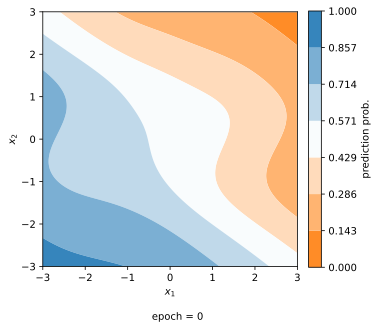

In [9]:
from models.training import Trainer, doublebackTrainer
import imageio, os

num_epochs = 10 #number of optimization runs in which the dataset is used for gradient decent
plotfreq = 5

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = 0, eps_comp = 0.2) 




fig_name_base = os.path.join('epoch_evo_circ','') #os independent file path
gif_name = fig_name_base + '.gif'
for epoch in range(0,num_epochs,plotfreq):
    print(f'\n{epoch + 1 =}')
    trainer_anode.train(dataloader, plotfreq)
    
    classification_evolution(anode, fig_name = fig_name_base + str(epoch), footnote = f'{epoch = }', plotlim = plotlim)
    
#     imgs.append(imageio.imread(fig_name_base + str(epoch) + '.png'))
#         # if not (num_steps == layer + 1): os.remove(fig_name_rob) #keep last image
# imageio.mimwrite(gif_name, imgs, fps = 1)

In [ ]:
from models.training import Trainer, doublebackTrainer
import imageio, os


trainer_rnode = doublebackTrainer(rnode, optimizer_rnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = 0.2) 




fig_name_base = os.path.join('epoch_evo_circ','rob') #os independent file path
gif_name = fig_name_base + '.gif'
for epoch in range(0,num_epochs,plotfreq):
    print(f'\n{epoch + 1 = }')
    trainer_rnode.train(dataloader, plotfreq)
    
    classification_evolution(rnode, fig_name = fig_name_base + str(epoch), footnote = f'epoch = {epoch + 1}', plotlim = plotlim)
    
#     imgs.append(imageio.imread(fig_name_base + str(epoch) + '.png'))
#         # if not (num_steps == layer + 1): os.remove(fig_name_rob) #keep last image
# imageio.mimwrite(gif_name, imgs, fps = 1)


epoch + 1 = 1
0.2

Iteration 0/45
Loss: 0.897
Robust Term Loss: 0.163
Accuracy: 0.531

Iteration 10/45
Loss: 0.804
Robust Term Loss: 0.142
Accuracy: 0.562

Iteration 20/45
Loss: 0.913
Robust Term Loss: 0.153
Accuracy: 0.406

Iteration 30/45
Loss: 0.883
Robust Term Loss: 0.150
Accuracy: 0.344

Iteration 40/45
Loss: 0.826
Robust Term Loss: 0.122
Accuracy: 0.391
Epoch 1: 0.842
0.2

Iteration 0/45
Loss: 0.768
Robust Term Loss: 0.115
Accuracy: 0.391

Iteration 10/45
Loss: 0.736
Robust Term Loss: 0.101
Accuracy: 0.406

Iteration 20/45
Loss: 0.794
Robust Term Loss: 0.106
Accuracy: 0.297

Iteration 30/45
Loss: 0.763
Robust Term Loss: 0.106
Accuracy: 0.297

Iteration 40/45
Loss: 0.748
Robust Term Loss: 0.084
Accuracy: 0.281
Epoch 2: 0.750
0.2

Iteration 0/45
Loss: 0.695
Robust Term Loss: 0.082
Accuracy: 0.328

Iteration 10/45
Loss: 0.688
Robust Term Loss: 0.073
Accuracy: 0.297

Iteration 20/45
Loss: 0.722
Robust Term Loss: 0.076
Accuracy: 0.266

Iteration 30/45
Loss: 0.696
Robust Term Loss: 0.

# Loss plots

In [ ]:
from enum import auto


def loss_evolution(trainer, epoch, filename = '', figsize = None):

    fig = plt.figure(dpi = 300, figsize=(figsize))
    labelsize = 10

    #plot whole loss history in semi-transparent
    plt.plot(trainer.histories['epoch_loss_history'], alpha = 0.5)
    plt.plot(trainer.histories['epoch_loss_rob_history'], '--', zorder = -1, alpha = 0.5)
    
    if trainer.eps > 0: #if the trainer has a robustness term
        standard_loss_term = [loss - rob for loss, rob in zip(trainer.histories['epoch_loss_history'],trainer.histories['epoch_loss_rob_history'])]
        plt.plot(standard_loss_term,'--', alpha = 0.5)
        leg = plt.legend(['total loss', 'gradient term', 'standard term'], prop= {'size': labelsize})
    else: leg = plt.legend(['standard loss', '(inaktive) gradient term'], prop= {'size': labelsize})
        
    #set alpha to 1
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    plt.plot(trainer.histories['epoch_loss_history'][0:epoch+1], color = 'C0')
    plt.scatter(epoch, trainer.histories['epoch_loss_history'][epoch])
    
    plt.plot(trainer.histories['epoch_loss_rob_history'][0:epoch +1], '--', color = 'C1')
    plt.scatter(epoch, trainer.histories['epoch_loss_rob_history'][epoch], color = 'C1')
    
    if trainer.eps > 0: #if the trainer has a robustness term
        plt.plot(standard_loss_term[0:epoch+1],'--', color = 'C2')
        plt.scatter(epoch, standard_loss_term[epoch], color = 'C2')
        
    plt.xlim(0, len(trainer.histories['epoch_loss_history']) - 1)
    # plt.ylim([0,0.75])
    plt.yticks(np.arange(0,1,0.25))
    plt.grid()
    ax = plt.gca()
    ax.yaxis.tick_right()
    ax.set_aspect('auto')
    if trainer.eps > 0:
        plt.ylabel('Loss Robust', size = labelsize)
        
    else:
        plt.ylabel('Loss Standard', size = labelsize)


    if not filename == '':
        plt.savefig(filename + '.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
        plt.clf()
        plt.close()
        
    else:
        plt.show()
        print('no filename given')
        
    
      


trainer_rnode.eps = 0.2


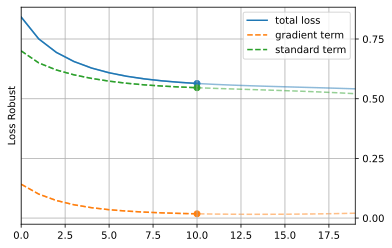

no filename given


In [ ]:
print(f'{trainer_rnode.eps = }')
loss_evolution(trainer_rnode, 10)

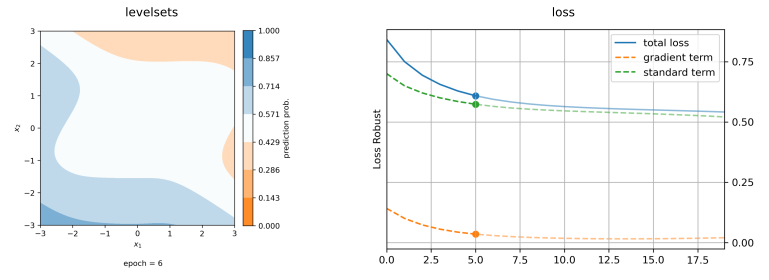

In [ ]:
epoch = 5

loss_evolution(trainer_rnode, epoch, 'loss_pic')
comparison_plot(fig_name_base + str(epoch) + '.png', 'levelsets', 'loss_pic.png', 'loss', 'test', show = True, figsize = (12,4))

## gif generation

In [ ]:
loss_imgs = []
fig_name_basis = os.path.join('epoch_evo_circ', '')
gif_name = os.path.join('epoch_evo_circ', 'loss_evo_comp.gif')
for epoch in range(0,num_epochs,plotfreq):
    print(epoch)
    loss_evolution(trainer_anode, epoch, 'loss_pic')
    fig1_name = fig_name_basis + str(epoch) + '.png'
    comparison_plot(fig1_name, 'levelsets', 'loss_pic.png', 'loss', 'comp_run.png', show = False, figsize = (12,4))
    
    loss_imgs.append(imageio.imread('comp_run.png'))
        # if not (num_steps == layer + 1): os.remove(fig_name_rob) #keep last image
imageio.mimwrite(gif_name, loss_imgs, fps = 1)

# for epoch in range(1,num_epochs+1,plotfreq):
#     if epoch not in [0, num_epochs//5, num_epochs//2, num_epochs-1]: os.remove(fig1_name) 

0
5
10
15


In [ ]:
def epoch_evo_gif(trainer, num_epochs, plotfreq, subfolder, title_left = 'levelsets', title_right = 'loss', fps = 1):
    if not os.path.exists(subfolder):
        os.makedirs(subfolder)
    
    imgs = []
    fig_name_basis = os.path.join(subfolder, '')
    gif_name = os.path.join(subfolder, 'loss_evo_comp.gif')
    for epoch in range(0,num_epochs,plotfreq):
        print(epoch)
        loss_evolution(trainer, epoch, 'loss_pic')
        fig1_name = fig_name_basis + str(epoch) + '.png'
        comparison_plot(fig1_name, title_left, 'loss_pic.png', title_right , 'comp_run.png', show = False, figsize = (12,4))
        
        imgs.append(imageio.imread('comp_run.png'))
            # if not (num_steps == layer + 1): os.remove(fig_name_rob) #keep last image
    imageio.mimwrite(gif_name, loss_imgs, fps = fps)


In [ ]:
epoch_evo_gif(trainer_anode, num_epochs, plotfreq, 'testsubfolder')

0


NameError: name 'loss_evolution' is not defined

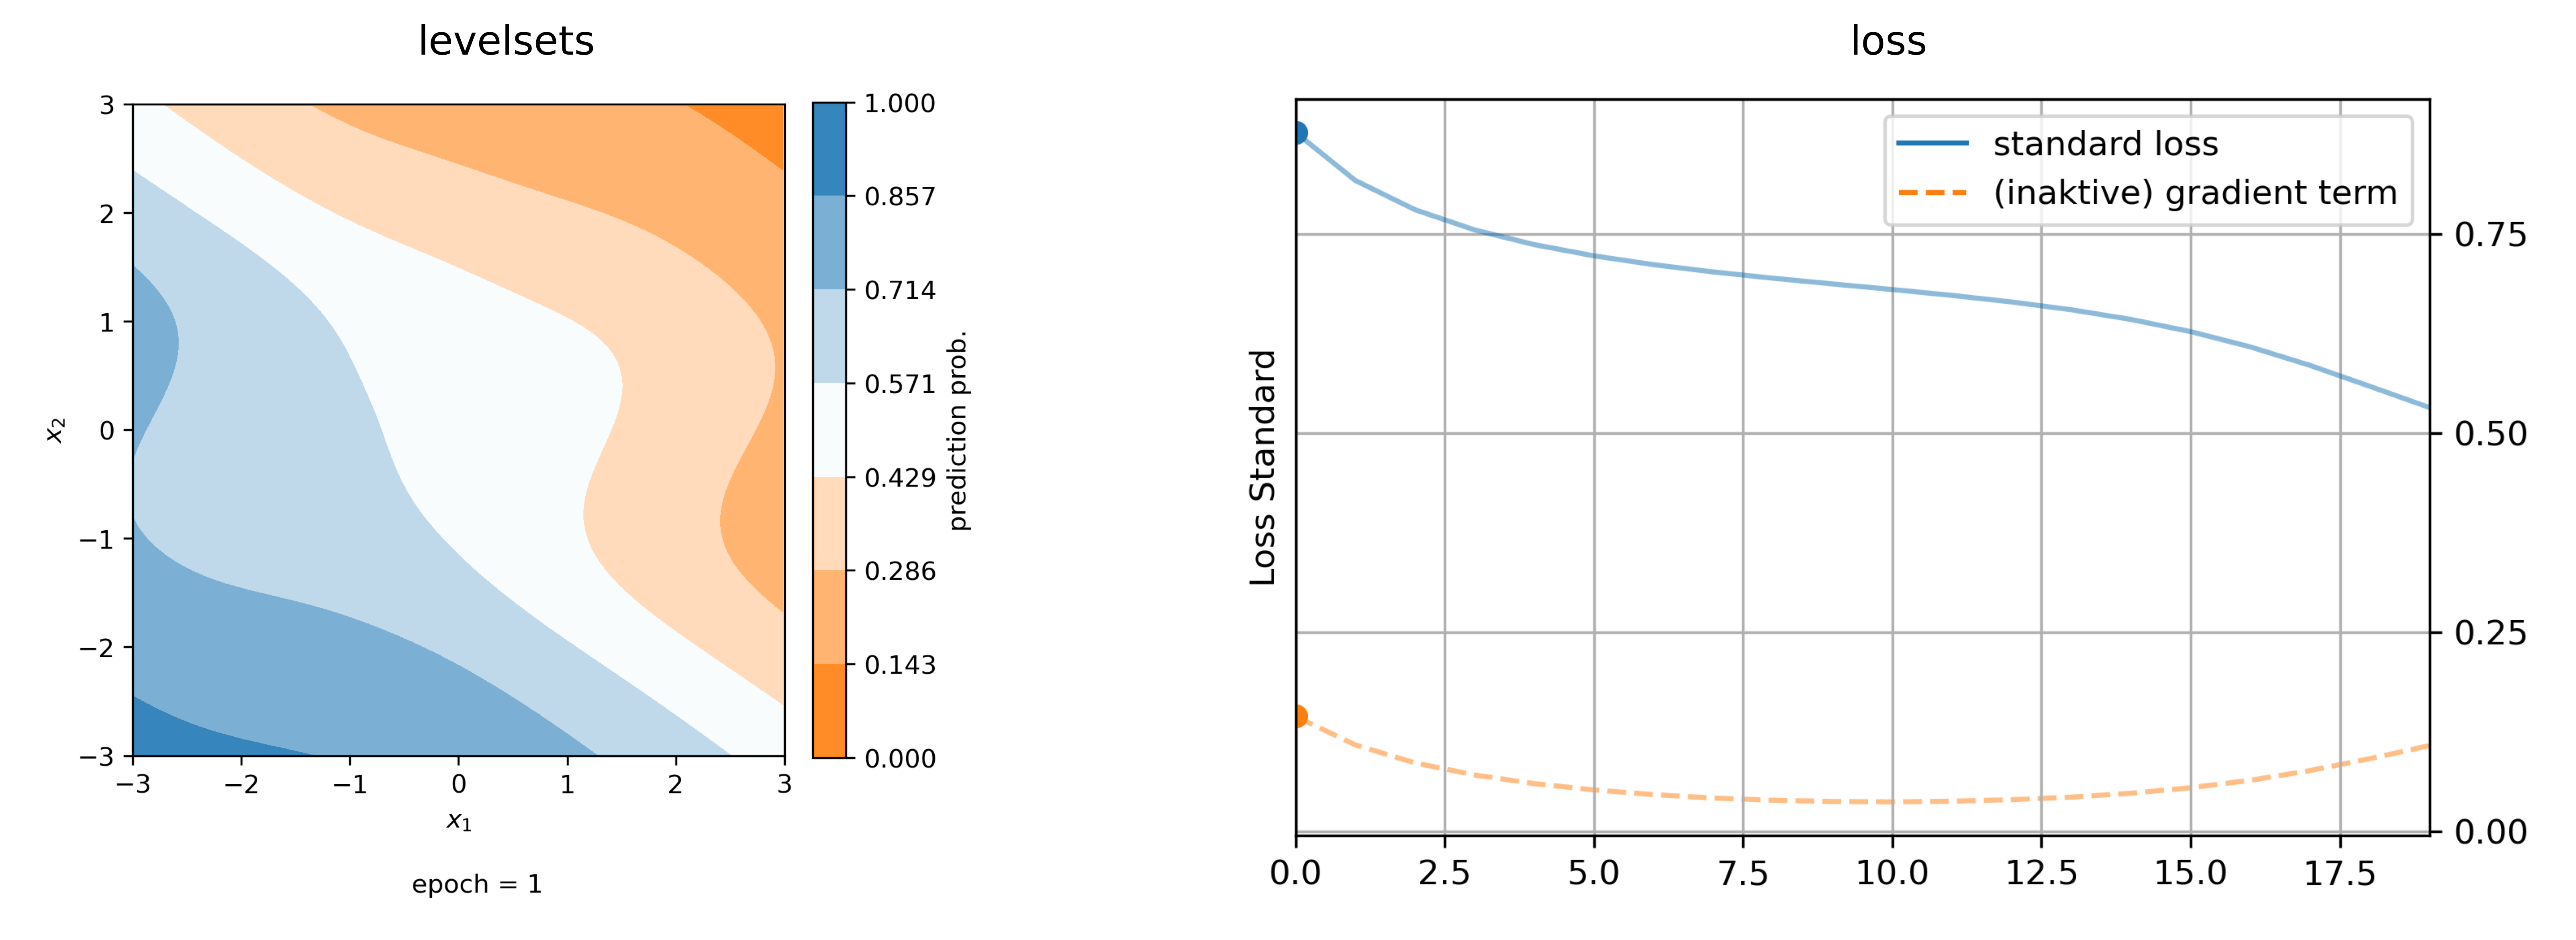

In [ ]:
from IPython.display import Image
Image(filename = gif_name, width = 800)

In [ ]:
loss_imgs = []
fig_name_base = os.path.join('epoch_evo_circ','rob')
gif_name = os.path.join('epoch_evo_circ', 'loss_evo_rob_comp.gif')
for epoch in range(0,num_epochs,plotfreq):
  
    loss_evolution(trainer_rnode, epoch, 'loss_pic')
    comparison_plot(fig_name_base + str(epoch) + '.png', 'levelsets', 'loss_pic.png', 'loss', 'comp_run.png', show = False, figsize = (12,4))
    
    loss_imgs.append(imageio.imread('comp_run' + '.png'))
        # if not (num_steps == layer + 1): os.remove(fig_name_rob) #keep last image
imageio.mimwrite(gif_name, loss_imgs, fps = 1)

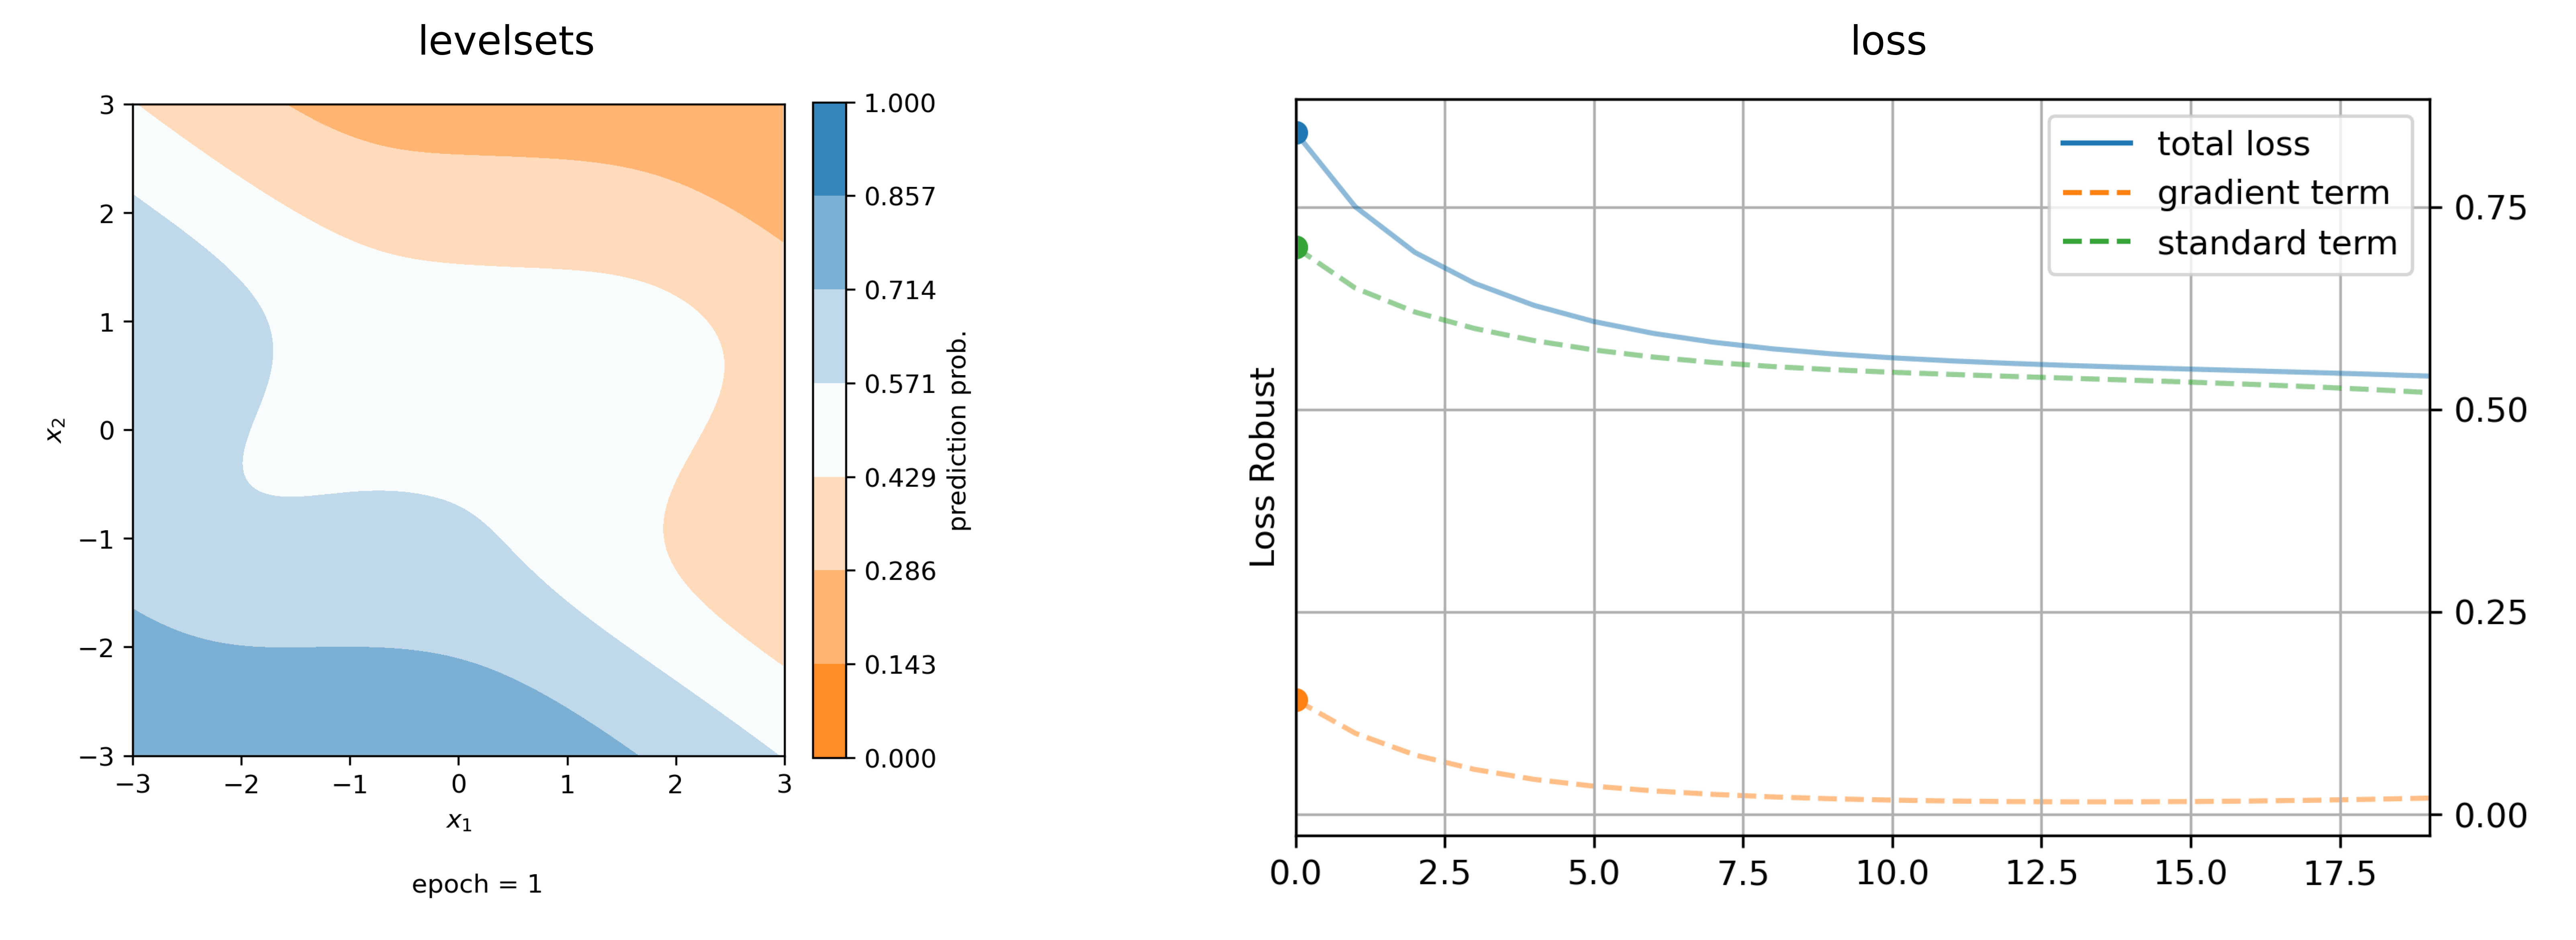

In [ ]:
from IPython.display import Image
Image(filename = gif_name, width = 800)